### Imports

In [49]:
import numpy as np
import os, os.path
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [50]:
%matplotlib inline
sys.path.append("..")

## OBJECT DETECTION IMPORTS

In [51]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.

By default we use <b>"Faster RCNN Inception v2 COCO" </b> model.


### Replace the INITIAL_DIR and enter the absolute path till Mask-Detection Folder downloaded from Git

In [52]:
INITIAL_DIR=r'C:\Users\Raghu\Mask'

In [53]:
MODEL_NAME = 'model_inference_graph'
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join(os.path.join(INITIAL_DIR,MODEL_NAME),'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/training', 'labels.pbtxt')

# No of classes we used to recognize faces.
NUM_CLASSES = 3

## Load a (frozen) Tensorflow model into memory.

In [54]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [55]:
label_map = label_map_util.load_labelmap(INITIAL_DIR+PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code
Used to load our test images as numpy array

In [56]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

## Detection
If you want to test the code with your images, just add the images to the <b>*test_images*</b> folder

In [57]:
test_folder = INITIAL_DIR + '/test_images'

### LOADING PATH OF IMAGES
Feel free to use any valid extensions you want for your images inside <b>*test_images*</b>

In [58]:
def get_images(test_folder):
    imgs = []
    valid_images = [".jpg",".jpeg",".png"]
    for f in os.listdir(test_folder):
        ext = os.path.splitext(f)[1]
        if ext.lower() in valid_images:
            imgs.append(os.path.join(test_folder, f))
            
    return imgs

TEST_IMAGE_PATHS=get_images(test_folder)
print("Total Images : {}".format(len(TEST_IMAGE_PATHS)))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

Total Images : 5


## ACTUAL DETECTION 
Change the `min_score_thresh` parameter inside the fuction `vis_util.visualize_boxes_and_labels_on_image_array` to specify the classes to set a threshold for confidence/score.

Processing image : 1
Processing image : 2
Processing image : 3
Processing image : 4
Processing image : 5


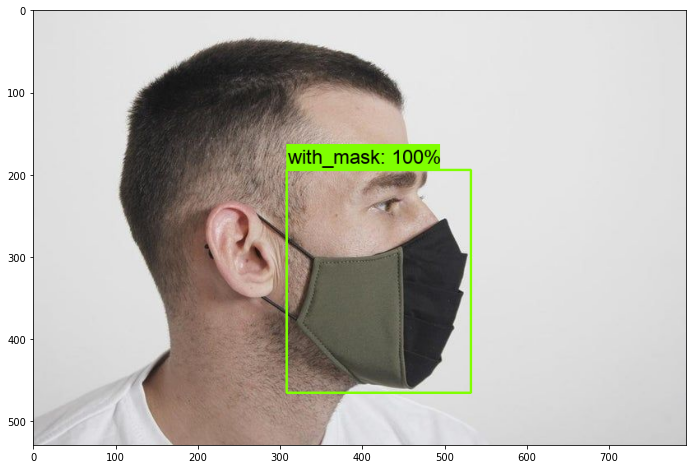

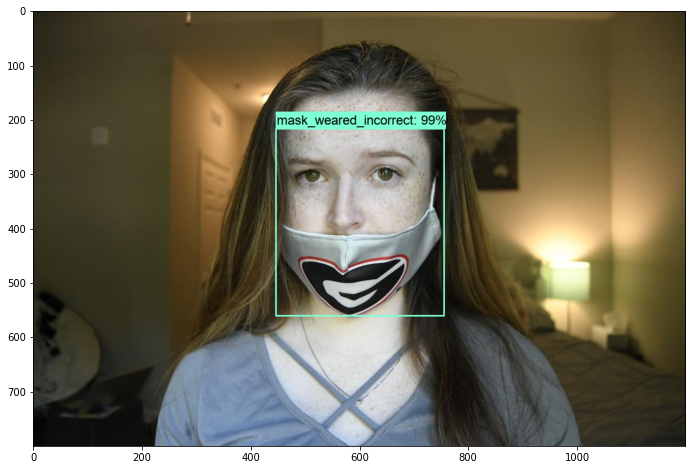

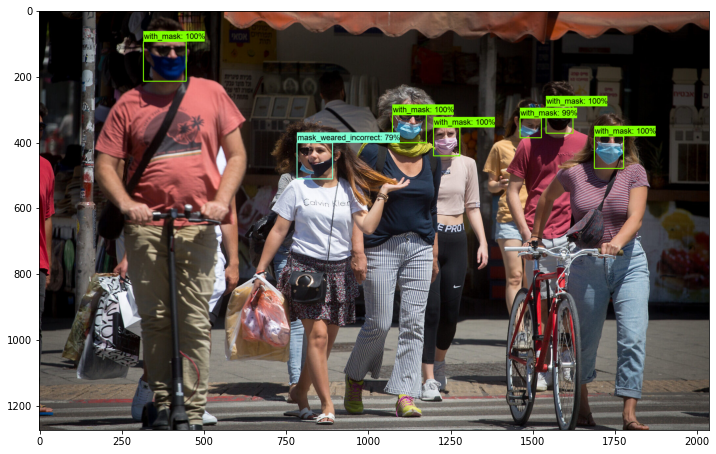

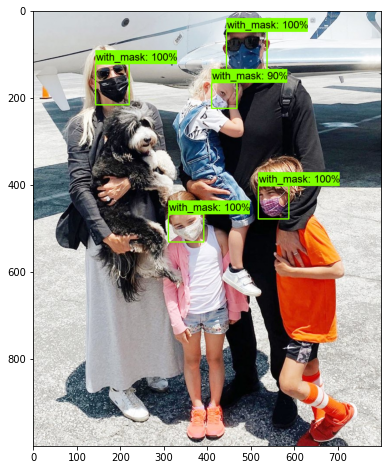

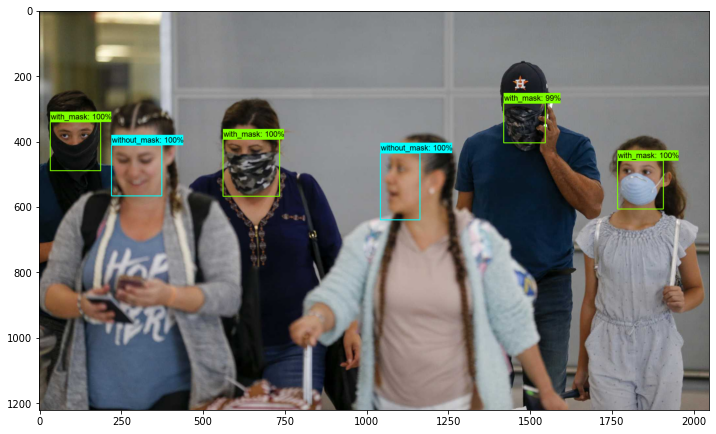

In [59]:
savepath=os.path.join(INITIAL_DIR,"outputs")

with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        i=0
        for number,image_path in enumerate(TEST_IMAGE_PATHS):
            print("Processing image : {}".format(number+1))
            filename=os.path.basename(image_path)
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=3,
            )

            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.savefig(os.path.join(savepath,filename))
            i=i+1